In [ ]:
import pandas as pd
import numpy as np

# load df_wikitext_sentences from csv
df_wikitext_sentences = pd.read_csv("../data/wikitext_sentences.csv")
# load df_controlled from csv
df_controlled = pd.read_csv("../data/controlled_sentences.csv")

In [7]:
df_wikitext_sentences.sample(10)

,Sentence,Target Index,Lemma,Category,Inflection Label,Word Form,Source Type
502,= = = Key to Paraguay = = =,3,key,Noun,positive,key,NaturalWikiText
15160,Development of Perl 5 is also continuing,6,continuing,Noun,singular,continuing,NaturalWikiText
4794,The Adventures of Roderick Random,1,adventure,Noun,base,adventures,NaturalWikiText
3078,Fourth Division ( tier 4 ),0,fourth,Noun,positive,fourth,NaturalWikiText
20317,""" He 's definitely the moral compass",5,moral,Noun,singular,moral,NaturalWikiText
3115,@ 7 million combined,3,combine,Verb,past,combined,NaturalWikiText
10214,Sickler was active from 1838 to about 1860,2,active,Noun,positive,active,NaturalWikiText
15259,Allah jang Palsoe also contains themes unrelat...,5,theme,Noun,base,themes,NaturalWikiText
14996,The esophagus carries food to the stomach,2,carry,Verb,plural,carries,NaturalWikiText
22581,The production was put together by Silas S,3,put,Verb,base,put,NaturalWikiText


In [28]:
df_controlled.groupby(['Category', 'Inflection Label']).sample(n=2).reset_index(drop=True)

,Sentence,Target Index,Lemma,Category,Inflection Label,Word Form,Dimension,Source Type
0,It is hard than before.,2,hard,Adjective,comparative,hard,Degree,Template
1,It is Greek than before.,2,Greek,Adjective,comparative,Greek,Degree,Template
2,It is the lengthy one.,3,lengthy,Adjective,superlative,lengthy,Degree,Template
3,It is the sure one.,3,sure,Adjective,superlative,sure,Degree,Template
4,I developed yesterday.,1,develop,Verb,past,developed,Tense/Aspect,Template
5,I sacred yesterday.,1,sacre,Verb,past,sacred,Tense/Aspect,Template


In [30]:
# how many unique lemmas in df_wikitext_sentences
unique_lemmas_wikitext = df_wikitext_sentences['Lemma'].nunique()
# how many unique lemmas in df_controlled
unique_lemmas_controlled = df_controlled['Lemma'].nunique()
print(f"Unique lemmas in wikitext sentences: {unique_lemmas_wikitext}")
print(f"Unique lemmas in controlled sentences: {unique_lemmas_controlled}")

# how many sentences in df_wikitext_sentences
num_sentences_wikitext = df_wikitext_sentences.shape[0]
# how many sentences in df_controlled
num_sentences_controlled = df_controlled.shape[0]
print(f"Number of sentences in wikitext sentences: {num_sentences_wikitext}")
print(f"Number of sentences in controlled sentences: {num_sentences_controlled}")

Unique lemmas in wikitext sentences: 2296
Unique lemmas in controlled sentences: 450
Number of sentences in wikitext sentences: 25918
Number of sentences in controlled sentences: 485


In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

dataset = "wikitext_sentences"
model_name = "pythia1.4b"
probe_dirs = [
    f"../output/probes/{dataset}_{model_name}_binary_inflection_dense",
    f"../output/probes/{dataset}_{model_name}_binary_inflection_sparse",
    f"../output/probes/{dataset}_{model_name}_lexeme_dense",
    f"../output/probes/{dataset}_{model_name}_lexeme_sparse",
    f"../output/probes/{dataset}_{model_name}_multiclass_inflection_dense",
    f"../output/probes/{dataset}_{model_name}_multiclass_inflection_sparse",   
]

def extract_probe_type(probe_dir):
    """Extracts the probe type from the directory name."""
    match = re.search(r"wikitext_sentences_(.*?)_(dense|sparse)", probe_dir)
    if match:
        return f"{match.group(1)}_{match.group(2)}"
    return "Unknown"

# Create a directory to save the figures
output_dir = "figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for probe_dir in probe_dirs:
    probe_type = extract_probe_type(probe_dir)
    csv_path = os.path.join(probe_dir, "probe_results.csv")

    try:
        df = pd.read_csv(csv_path)

        # Determine whether to plot inflection or lexeme accuracies
        if "inflection" in probe_type:
            task_col = "Inflection"
            control_col = "Inflection_Control"
        else:
            task_col = "Lexeme"
            control_col = "Lexeme_Control"

        # Plotting
        fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure for each plot
        ax.bar(df['Layer'], df[task_col], label=f"{task_col} Accuracy", alpha=0.7)
        ax.bar(df['Layer'], df[control_col], label=f"{control_col} Accuracy", alpha=0.7)
        ax.set_xlabel("Layer")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{probe_type}: {task_col} vs. {control_col} Accuracy")
        ax.legend()
        ax.set_ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy

        plt.tight_layout()

        # Save the figure to the output directory
        output_path = os.path.join(output_dir, f"{dataset}_{probe_type}.png")
        plt.savefig(output_path)
        plt.close(fig)  # Close the figure to free memory

    except FileNotFoundError:
        fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure for each plot
        ax.text(0.5, 0.5, f"CSV Not Found for {probe_type}", ha='center', va='center', color='red')
        ax.axis("off")
        plt.tight_layout()

        # Save the figure to the output directory
        output_path = os.path.join(output_dir, f"{probe_type}_error.png")
        plt.savefig(output_path)
        plt.close(fig)  # Close the figure to free memory

Dataset loaded with 25918 examples.

Lemma Distribution (count per class):
Lemma
fly         40
live        35
well        35
go          35
take        35
            ..
barry        5
survivor     5
generate     5
seeme        5
renew        5
Name: count, Length: 2296, dtype: int64 



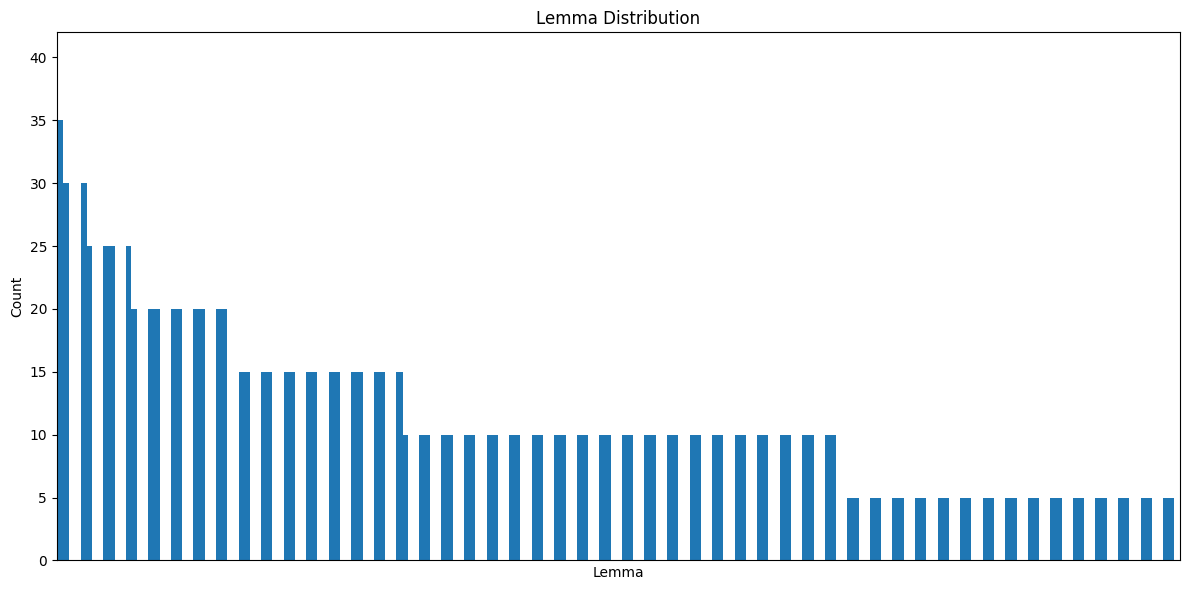

Inflection Label Distribution (count per class):
Inflection Label
singular    9584
base        8464
positive    3425
past        2245
plural      2200
Name: count, dtype: int64 



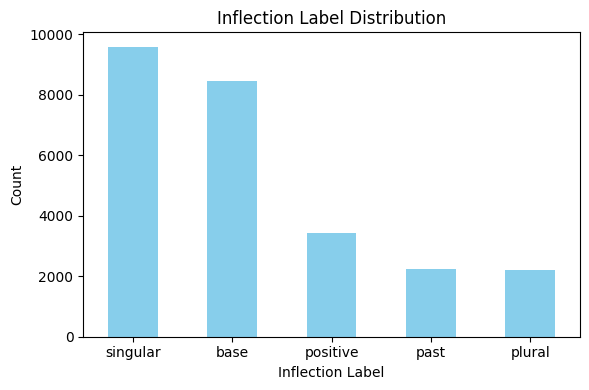

Examples of Lemma Tokenization:
   Lemma Tokenized Lemma
0  right         [right]
1  right         [right]
2  right         [right]
3  right         [right]
4  right         [right]
5  right         [right]
6  right         [right]
7  right         [right]
8  right         [right]
9  right         [right] 

Number of lemma instances tokenized into multiple tokens: 10145
Percentage of multi-token lemmas: 39.14%

Unique lemmas tokenized into multiple tokens: 1149 out of 2296
Missing values in 'Lemma': 0
Missing values in 'Inflection Label': 0
Missing values in 'Sentence': 0
Missing values in 'Target Index': 0

Total number of examples: 25918
Number of unique lemmas: 2296
Number of unique inflection labels: 5


In [38]:
# Update the CSV file path as necessary
csv_file = "../data/wikitext_sentences.csv"  # Change this to the path of your dataset CSV file

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file)
print(f"Dataset loaded with {len(df)} examples.\n")

# --- 1. Dataset Balance Diagnostics ---

# Check distribution of Lemma labels
print("Lemma Distribution (count per class):")
lemma_counts = df["Lemma"].value_counts()
print(lemma_counts, "\n")

# Plot the lemma distribution as a bar chart (if there are many classes, you might want to limit the number displayed)
plt.figure(figsize=(12, 6))
lemma_counts.plot(kind="bar")
plt.title("Lemma Distribution")
plt.xlabel("Lemma")
plt.ylabel("Count")
plt.xticks([])  # Remove x-axis labels
plt.tight_layout()
plt.show()

# Check distribution of inflection labels (e.g., "present" vs. "past")
print("Inflection Label Distribution (count per class):")
inflection_counts = df["Inflection Label"].value_counts()
print(inflection_counts, "\n")

# Plot the inflection label distribution
plt.figure(figsize=(6, 4))
inflection_counts.plot(kind="bar", color='skyblue')
plt.title("Inflection Label Distribution")
plt.xlabel("Inflection Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 2. Tokenization Diagnostics for Lemma ---

# Load GPT-2 tokenizer (or change to the appropriate model)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Define a helper function to tokenize a given word
def tokenize_word(word):
    tokens = tokenizer.tokenize(word)
    return tokens

# Apply tokenization to the Lemma column (ensure it is string type)
df["Tokenized Lemma"] = df["Lemma"].astype(str).apply(tokenize_word)

# Display a few examples of tokenized Lemmas
print("Examples of Lemma Tokenization:")
print(df[["Lemma", "Tokenized Lemma"]].head(10), "\n")

# Diagnose how many Lemma instances are tokenized into multiple tokens
df["Num_Tokens"] = df["Tokenized Lemma"].apply(len)
multi_token_count = (df["Num_Tokens"] > 1).sum()
print(f"Number of lemma instances tokenized into multiple tokens: {multi_token_count}")
print(f"Percentage of multi-token lemmas: {100 * multi_token_count/len(df):.2f}%\n")

# Additionally, check the uniqueness across Lemma types:
unique_lemmas = df["Lemma"].dropna().unique()
multi_token_unique = sum(1 for lex in unique_lemmas if len(tokenize_word(str(lex))) > 1)
print(f"Unique lemmas tokenized into multiple tokens: {multi_token_unique} out of {len(unique_lemmas)}")

# --- 3. Additional Diagnostics ---

# You can include other diagnostics as needed, for instance:
# - Checking for missing or NaN values in key columns
for column in ["Lemma", "Inflection Label", "Sentence", "Target Index"]:
    missing = df[column].isna().sum()
    print(f"Missing values in '{column}': {missing}")

# - Basic statistics: total number of examples, unique lemmas, etc.
print(f"\nTotal number of examples: {len(df)}")
print(f"Number of unique lemmas: {len(unique_lemmas)}")
print(f"Number of unique inflection labels: {df['Inflection Label'].nunique()}")
